In [1]:
# obtener el dataset urban100
!wget https://data.deepai.org/set5.zip
!unzip -qq set5.zip
!cd set5/
!unzip -qq set5/SR_testing_datasets.zip -d testing
!unzip -qq set5/SR_training_datasets.zip -d training

--2021-05-31 15:31:48--  https://data.deepai.org/set5.zip
Resolving data.deepai.org (data.deepai.org)... 138.201.36.183
Connecting to data.deepai.org (data.deepai.org)|138.201.36.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407631796 (389M) [application/x-zip-compressed]
Saving to: ‘set5.zip’

set5.zip            100%[===================>] 388.75M  32.5MB/s    in 13s     

2021-05-31 15:32:01 (30.9 MB/s) - ‘set5.zip’ saved [407631796/407631796]



In [2]:
#importar las librerias necesarias
import os
import math
import sys
import numpy as np
import cv2 as cv
from PIL import Image
from matplotlib import pyplot as plt

from skimage import data, img_as_float
from skimage.metrics import structural_similarity
from skimage.metrics import mean_squared_error
from skimage.metrics import peak_signal_noise_ratio

In [4]:
if not os.path.exists('downsampled'):
    os.makedirs('downsampled')
if not os.path.exists('upsampled'):
    os.makedirs('upsampled')

orig_path = "/content/testing/Urban100"
down_path = "/content/downsampled"
up_path = "/content/upsampled"
n_img = 100

In [5]:
# reducir el tamaño de las primeras 80 iamgenes 
def downsample_images(factor):
  print(f"Runing downsampler x{factor}...")
  for i in range(n_img):
    # leer imagen
    img = cv.imread(f"{orig_path}/img_{str(i+1).zfill(3)}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    # downsample horizontal
    for j in range(factor):
      img = np.delete(img, range(1, img.shape[0], 2), axis=0)

    # downsample vertical
    for k in range(factor):
      img = np.delete(img, range(1, img.shape[1], 2), axis=1)

    # save image to disk
    Image.fromarray(img).save(f"{down_path}/img_{str(i+1).zfill(3)}.png")
  print(f"Done\n")


In [6]:
# apply bicubic interpolation
def bicubic_interpolation(factor):
  print(f"Runing bicubic interpolator x{factor}...")
  for i in range(n_img):
    img = cv.imread(f"{down_path}/img_{str(i+1).zfill(3)}.png")
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    up = img.resize((img.width*(2**factor), img.height*(2**factor)), resample=Image.BICUBIC)
    up.save(f"{up_path}/img_{str(i+1).zfill(3)}.png")

  print(f"Done\n")


In [7]:
# calculate mse, psnr and ssim
def calculate_errors():
  print(f"calculating errors...")
  results = {
      'mse': [],
      'psnr': [],
      'ssim': [],
  }
  for i in range(n_img):
    img_orig = cv.imread(f"{orig_path}/img_{str(i+1).zfill(3)}.png")
    img_up = cv.imread(f"{up_path}/img_{str(i+1).zfill(3)}.png")

    mse_val = mean_squared_error(img_orig, img_up)
    psnr_val = peak_signal_noise_ratio(img_orig, img_up, data_range=img_up.max() - img_up.min())
    ssim_val = structural_similarity(img_orig, img_up, data_range=img_up.max() - img_up.min(), multichannel=True)

    results['mse'].append(mse_val)
    results['psnr'].append(psnr_val)
    results['ssim'].append(ssim_val)

  print(f"Done\n")
  return results

In [8]:
# ejecutar interpolacion bicubica
def run_bicubic(factor):
  downsample_images(factor)
  bicubic_interpolation(factor)
  # calcular errores
  return calculate_errors()


In [17]:
all_errors = []
for factor in [1]:
  all_errors.append(run_bicubic(factor))

Runing downsampler x1...
Done

Runing bicubic interpolator x1...
Done

calculating errors...
Done



In [14]:
print( np.array(all_errors[1]['ssim']).mean() )
print( np.array(all_errors[1]['psnr']).mean() )

0.5370026604280196
18.332032024250537


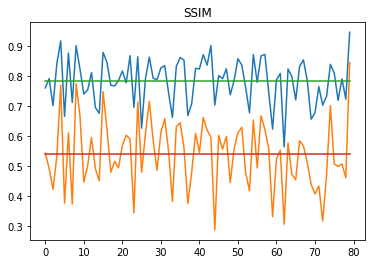

In [ ]:
plt.title('SSIM')
plt.plot(range(n_img), all_errors[0]['ssim'], label='SSIM x2')
plt.plot(range(n_img), all_errors[1]['ssim'], label='SSIM x4')

plt.plot(range(n_img), np.array(all_errors[0]['ssim']).mean().repeat(n_img), label='Mean SSIM x2')
plt.plot(range(n_img), np.array(all_errors[1]['ssim']).mean().repeat(n_img), label='Mean SSIM x4')

plt.show()